## 4-2. トロッター分解を用いた量子シミュレーション

この節では量子系のダイナミクスをシミュレーションする手法の一つである、トロッター分解に基づいたダイナミクスシミュレーションを紹介する。この手法はダイナミクスのシミュレーションとしてはある意味最も愚直な手法であり、NISQデバイスでも一定の規模の問題までは動作する。   
ここでは、1次元の横磁場イジングモデルという物理系の量子ダイナミクスをシミュレートしてみる。

### トロッター分解とは

[（リー・）トロッター分解](https://ja.wikipedia.org/wiki/リー・トロッター積公式)とは、正方行列$A,B$の和の指数関数を、それぞれの指数関数の積に近似する公式である：

$$
e^{\delta (A+B)} = e^{\delta A} \cdot e^{\delta B} +  O\left( \delta^2 \right).
$$

ここで$O$は[2.3節](2.3_quantum_Fourier_transform.ipynb)コラムで紹介したオーダー記法であり、近似の大体の精度を表す。（$A,B$が行列なので、$e^{A+B}\neq e^A\cdot e^B$ であることに注意）

### トロッター分解を用いた量子シミュレーションの仕組み

前節で学んだように、量子状態の時間発展はシュレディンガー方程式$i\frac{\partial}{\partial t}|\psi(t)\rangle = H|\psi(t)\rangle$に従う（$\hbar=1$とした）。特に、ハミルトニアン$H$が時間に依存しない場合、時間$t$が経った時の状態は$|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$となる（$|\psi(0)\rangle$は初期状態）。つまり、量子系のダイナミクスのシミュレーションでは$e^{-iHt}$という演算子が計算できれば良いのだが、$n$量子ビット系だと$H$は$2^n$次元となって非常に大きな行列になる。ゆえに古典コンピュータでこの指数関数を計算するのは難しいし、量子コンピュータでもあらゆる$2^n$次元の行列$H$の指数関数を計算するのは難しいと考えられている。

しかし、ハミルトニアンが**特定の構造**を持つ場合、量子コンピュータは$e^{-iHt}$を効率よく計算できる。その際に用いるのがトロッター分解である。   
具体例で考えてみよう。$n$量子ビットからなるイジングモデル（後述）$H = \sum_{i=1}^{n-1} Z_i Z_{i+1}$ を考える。この$H$は$2^n$次元の行列であるが、トロッター分解を用いると$e^{-iH t}$を

$$
 e^{-iHt} = e^{-i\left(\sum_{i=1}^{n-1} Z_i Z_{i+1}\right) t} = \left(e^{-i(Z_1 Z_2 + Z_2 Z_3 \cdots )\frac{t}{M}}\right)^M
 \approx \left(e^{-i(Z_1 Z_2)\frac{t}{M}}\cdot e^{-i(Z_2 Z_3)\frac{t}{M}}\cdot\cdots \right)^M  \tag{1}
$$

のように分解できる。$M$は$e^{-iHt}$の作用を分割する総数で、近似の精度$O\left((t/M)^2\right)$が十分小さくなるように選んでおく。   
ここで最後の式に注目すると、小さい行列(2量子ビットゲート、4次元)である $e^{-i(Z_i Z_{i+1})\frac{t}{M}}$の$nM$個の積でかけていることが分かる。つまり、**指数的に大きな行列の作用を、小さな行列（2量子ビットゲート）の多項式個の作用の積で書き表すことができた**のである。

このように、ハミルトニアンが少数の項の和で書ける場合には、トロッター分解を用いて量子コンピュータで高速に計算を行うことができるのだ。

※ ちなみに、物理・量子化学の分野で興味のあるハミルトニアンは、大抵は効率的なトロッター分解ができる形をしている。

### 量子ダイナミクスの実装(1)：イジングモデル
量子シミュレーションを実装する具体的な系として、イジングモデルというものを考えてみよう。   
(物理学に詳しくない読者は、とりあえず定義だけ受け入れて計算を追うので問題ない)

物質が磁場に反応する性質を磁性というが、ミクロな世界では電子や原子核が非常に小さな磁性を持ち、**スピン**と呼ばれている。大雑把には、スピンとは小さな磁石のことであると思って良い。私たちが日常目にする磁石は、物質中の電子（原子核）のスピンが示す小さな磁性が綺麗に揃った結果、巨大な磁性が現れたものなのである。

イジングモデルは、そんな物質中のスピンを振る舞いを記述するモデルで、磁石の本質を取り出したモデルとして考案された。定義は以下の通りである。

$$
H = J \sum_{i=1}^{n} Z_i Z_{i+1}
$$

ここで$J$はモデルのパラメータ、$n$はスピンを持つ粒子の数、$Z_i$は$i$番目の粒子のスピンの$z$軸方向の成分を表す。前節で学んだように、物理量はオブザーバブルというエルミート演算子で表されるので、スピンが示す磁化（磁力の強さ）も演算子で表される。空間は三次元だから、独立な磁化の成分として$x,y,z$軸の三方向の磁化が考えられ、それぞれ対応する演算子は$X,Y,Z$である。（パウリ演算子$X,Y,Z$の名前の由来はここから来ている）   
ざっくりいうと、$i$番目の粒子＝$i$番目の量子ビットであり、$Z|0\rangle=|0\rangle$, $Z|1\rangle= -|1\rangle$だから、$|0\rangle$はスピンが$+z$方向を向いている状態、$|1\rangle$はスピンが$-z$方向を向いている状態である。

このモデルを構成する$Z_i Z_{i+1}$は隣り合う量子ビット間の相互作用を表している。$J>0$の時、 $(Z_i,Z_{i+1})=(1,1),(-1,-1)$ で $Z_i Z_{i+1}=1$、$(Z_i,Z_{i+1})=(1,-1),(-1,1)$ で $Z_i Z_{i+1}=-1$ だから、エネルギーが低いのはスピンが互い違いになる場合$|010101\cdots\rangle$である。逆に$J<0$ではスピンが揃った場合 $|000\cdots\rangle, |111\cdots\rangle$ がエネルギーが低く安定になり、系は巨大な磁化を持った磁石として振る舞う。

さて、実はこのモデルそのものは量子コンピュータを使わなくても簡単に解けてしまうが、まずはこのモデルでトロッター分解の基本を実装してみよう。$e^{-iHt}$のトロッター分解は(1)式で導いているので、必要になるのは$e^{-i \delta Z_i Z_{i+1}}$というゲートをどのように実装するかである。これは次のようにすれば良い（計算して確かめてみてほしい）：

$$
e^{-i \delta Z_i Z_{i+1}} = \operatorname{CNOT}_{i,i+1} \cdot e^{-i\delta Z_{i+1}} \cdot \operatorname{CNOT}_{i,i+1}.
$$

今回は**z方向の全磁化**

$$
\left\langle\psi\left|\sum_{i=1}^{n} Z_i\right|\psi\right\rangle
$$

という物理量に着目して、その時間変化を追いかける。   
**初期状態はスピンが**$+z$**方向に揃った**$|000\cdots\rangle$とし、便宜上、系が周期的になっているとして$Z_{n+1}$ は $Z_1$ と同一視する。

In [ ]:
## Google Colaboratoryの場合・Qulacsがインストールされていないlocal環境の場合のみ実行してください
!pip install qulacs

In [1]:
#必要なライブラリをインポート
from qulacs import QuantumState,QuantumCircuit, Observable, PauliOperator
from qulacs.gate import X,Z,RX,RY,RZ,CNOT,merge,DenseMatrix,add
from qulacs.state import inner_product
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

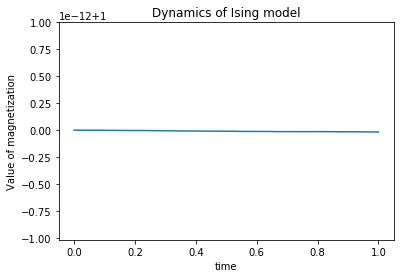

In [2]:
# 今回は粒子6個の系を想定する。
nqubits = 6
# ダイナミクスをシミュレーションする時間
t = 1.0
# トロッター分解の分割数
M = 100
# 時間の刻み幅
delta = t/M

## 全磁化に対応するオブザーバブルを準備しておく
magnetization_obs = Observable(nqubits) 
for i in range(nqubits):
     magnetization_obs.add_operator(PauliOperator("Z "+str(i), 1.0/nqubits))
        

## 初期状態は|000000>
state = QuantumState(nqubits)
state.set_zero_state() 

# トロッター分解の1回分、e^{iZ_1Z_2*delta}*e^{iZ_2Z_3*delta}*...e^{iZ_nZ_1*delta} を量子ゲートに変換
circuit_trotter_Ising = QuantumCircuit(nqubits)
for i in range(nqubits):
    circuit_trotter_Ising.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_Ising.add_RZ_gate((i+1)%nqubits,2*delta) ## RZ(a)=exp(i*a/2*Z)に注意
    circuit_trotter_Ising.add_CNOT_gate(i,(i+1)%(nqubits))

## 時間と磁化を記録するリスト
x = [i*delta for i in range(M+1)]
y = []

#t=0の時の全磁化のみ先に計算
y.append( magnetization_obs.get_expectation_value(state) )

#t=0以降の全磁化を計算
for i in range(M):
    # delta=t/Mだけ時間発展
    circuit_trotter_Ising.update_quantum_state(state)
    # 磁化を計算して記録
    y.append(magnetization_obs.get_expectation_value(state))

#グラフの描画
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of Ising model")
plt.plot(x, y, "-")
plt.show()

この結果を見ると分かるように、$z$方向の全磁化は一定である（縦軸のスケールにも注意）。
実は、イジングモデルでは$z$方向の相互作用しかないので、$z$方向の全磁化も保存してしまうのだ。これでは面白くないので、次は$x$軸方向に磁場を加えた横磁場イジングモデルの時間発展を見てみよう。

### 量子ダイナミクスの実装(2)：横磁場イジングモデル
イジングモデルに、$x$軸方向の一様な磁場をかけた横磁場イジングモデルを考えよう。

$$
H = \sum_{i=1}^n Z_i Z_{i+1} + h\sum_{i=1}^n X_i  
$$ 

この$h$は横磁場の強さを表す係数で、$X_i$は$i$番目の粒子の$x$方向の磁化を表すパウリ演算子（オブザーバブル）である。

このモデルでトロッター分解を行うと、先ほどのイジングモデルに加えて$e^{-ih X_1 \frac{t}{M}} \cdots e^{-ih X_n \frac{t}{M}}$という項が加わることになる。   
では実際にこのモデルでの全磁化の動きを見てみよう。

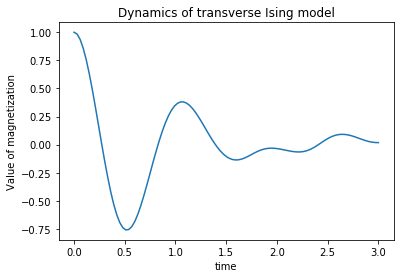

In [3]:
# 今回は粒子6個の系を想定する。
nqubits = 6
# ダイナミクスをシミュレーションする時間
t = 3.0
# トロッター分解の分割数
M = 100
# 時間の刻み幅
delta = t/M

## 横磁場の強さ
h = 3.


## 全磁化に対応するオブザーバブルを準備しておく
magnetization_obs = Observable(nqubits) 
for i in range(nqubits):
     magnetization_obs.add_operator(PauliOperator("Z "+str(i), 1.0/nqubits))

## 初期状態は|000000>
state = QuantumState(nqubits)
state.set_zero_state() 

# トロッター分解の1回分、
# e^{iZ_1Z_2*delta}*e^{iZ_2Z_3*delta}*...e^{iZ_nZ_1*delta} * e^{i X_1*delta}*...*e^{i X_n*delta} を量子ゲートに変換
circuit_trotter_transIsing = QuantumCircuit(nqubits)
for i in range(nqubits):
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RZ_gate((i+1)%nqubits,2*delta) ## RZ(a)=exp(i*a/2*Z)に注意
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RX_gate(i, 2*delta*h) ## RX(a)=exp(i*a/2*X)に注意

## 時間と磁化を記録するリスト
x = [i*delta for i in range(M+1)]
y = []

#t=0の時の全磁化のみ先に計算
y.append( magnetization_obs.get_expectation_value(state) )

#t=0以降の全磁化を計算
for i in range(M):
    # delta=t/Mだけ時間発展
    circuit_trotter_transIsing.update_quantum_state(state)
    # 磁化を計算して記録
    y.append(magnetization_obs.get_expectation_value(state))

#グラフの描画
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of transverse Ising model")
plt.plot(x, y, "-")
plt.show()

$h=0$のイジングモデルの場合は全磁化の値が一定だったのに対し、横磁場$h=3$を入れた横磁場イジングモデルの場合は全磁化の値が負の値にまで一旦下がっている点で大きく違う。   
これは横磁場($x$方向の磁場)の影響で$z$方向に揃っていたスピンが乱れて乱雑になり、結果として全磁化の値が変化していると考えれば良い。興味のある読者は$h$を強くして計算してみると、磁化の減少するスピードが速くなることが分かるであろう。

### 量子ダイナミクスの実装(3)：厳密解との比較
トロッター分解には誤差がある。上で計算したダイナミクスがどれほどの精度のなのか、$e^{-iHt}$を直接計算した厳密なダイナミクスと比べてみよう。

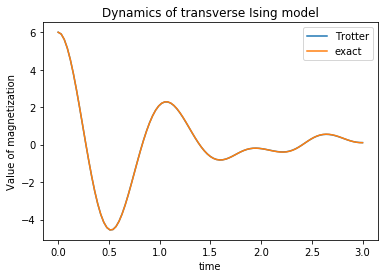

In [4]:
# 今回は粒子6個の系を想定する。
nqubits = 6
# ダイナミクスをシミュレーションする時間
t = 3.0
# トロッター分解の分割数
M = 100
# 時間の刻み幅
delta = t/M

## 横磁場の強さ
h = 3.

## 全磁化に対応するオブザーバブル. 
magnetization_obs = Observable(nqubits) 
for i in range(nqubits):
     magnetization_obs.add_operator(PauliOperator("Z "+str(i), 1.0))


## 初期状態は|000000>
state_trotter = QuantumState(nqubits)
state_trotter.set_zero_state() 
state_exact = QuantumState(nqubits)
state_exact.set_zero_state() 

# トロッター分解の1回分、
# e^{iZ_1Z_2*delta}*e^{iZ_2Z_3*delta}*...e^{iZ_nZ_1*delta} * e^{i X_1*delta}*...*e^{i X_n*delta} を量子ゲートに変換
circuit_trotter_transIsing = QuantumCircuit(nqubits)
for i in range(nqubits):
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RZ_gate((i+1)%nqubits,2*delta) ## RZ(a)=exp(i*a/2*Z)に注意
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RX_gate(i, 2*delta*h) ## RX(a)=exp(i*a/2*X)に注意

# e^{-iHt}を直接対角化する。Hの行列表現を得るために、gateを生成してそのmatrixを取得する
zz_matrix = np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]]) ## Z_i*Z_{i+1}の行列表示
hx_matrix = h*np.array( [ [0,1], [1,0] ] )
zz = DenseMatrix([0,1], zz_matrix) ## 0~1間の相互作用
hx = DenseMatrix(0, hx_matrix) ## 0サイトへの横磁場
## qulacs.gate.addを用いて、1以降のサイトの相互作用と横磁場を足していく
for i in range(1, nqubits): 
    zz = add(zz, DenseMatrix([i,(i+1)%nqubits], zz_matrix))
    hx = add(hx, DenseMatrix(i, hx_matrix) ) 
## 最終的なハミルトニアン
ham = add(zz, hx) 
matrix = ham.get_matrix() #行列の取得
eigenvalue, P = np.linalg.eigh(np.array(matrix)) #取得した行列の固有値、固有ベクトルを取得
## e^{-i*H*delta}を行列として作る
e_iHdelta = np.diag(np.exp(-1.0j*eigenvalue*delta))
e_iHdelta = np.dot(P, np.dot(e_iHdelta, P.T))
## 回路に変換
circuit_exact_transIsing = QuantumCircuit(nqubits)
circuit_exact_transIsing.add_dense_matrix_gate( np.arange(nqubits), e_iHdelta)


## 時間と磁化を記録するリスト
x = [i*delta for i in range(M+1)]
y_trotter = []
y_exact = []
#t=0の時の全磁化のみ先に計算
y_trotter.append( magnetization_obs.get_expectation_value(state_trotter) )
y_exact.append( magnetization_obs.get_expectation_value(state_exact) )

#t=0以降の全磁化を計算
for i in range(M):
    # delta=t/Mだけ時間発展
    circuit_trotter_transIsing.update_quantum_state(state_trotter)
    circuit_exact_transIsing.update_quantum_state(state_exact)
    # 磁化を計算して記録
    y_trotter.append( magnetization_obs.get_expectation_value(state_trotter) )
    y_exact.append( magnetization_obs.get_expectation_value(state_exact) )

#グラフの描画
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of transverse Ising model")
plt.plot(x, y_trotter, "-", label="Trotter")
plt.plot(x, y_exact, "-", label="exact")
plt.legend()
plt.show()

この範囲では、どうやらほぼ一致しているようだ。誤差を見てみよう。

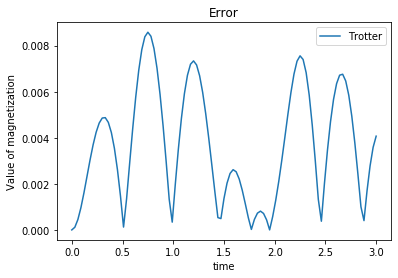

In [5]:
#グラフの描画
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Error")
plt.plot(x, np.abs(np.array(y_trotter) - np.array(y_exact)), "-", label="Trotter")
plt.legend()
plt.show()

興味のある読者は、分割数$M$を荒くしたり、時間$t$を大きくしたり色々と試してみてほしい。